### Group 92 Project Proposal
- Members: Alan, Bowen, Jia Yi, Kiki

# Predicting Heart Disease with Patient Health Information

## Introduction

Can we use the health report information to predict whether a patient has heart disease?

Heart disease is defined as the buildup of plaque in the heart's arteries that could lead to a heart attack/failure, which leads to death in many cases.

As the second leading cause of death in Canada, about 1 in 12 Canadian adults aged 20 and older live with a diagnosed heart disease, and the death rate of a heart disease is 2.9 times higher for them versus those without. However, early detection and management can help keep this illness under control. Hence, this project aims to build a classification model that can predict and diagnose whether a patient has a heart disease so that early intervention can take place to increase chances of rehabilitation.

The dataset chosen dates back to 1988 and consists of 4 databases from Cleveland, Hungary, Switzerland, and Long Beach V. The "target" field refers to the presence of heart disease in the patient. The integer valued ‘0’ means there is no disease, while the integer valued ‘1’ shows presence of heart disease.

## Methods & Data Analysis

We load the necessary libraries and adjust the options so that tables only print a maximum of 10 rows.

In [12]:
library(tidyverse)
library(tidymodels)                
library("ggplot2")  
options(repr.matrix.max.rows = 10)

### Reading and Wrangling Data

#### The heart dataset has the following columns in the following order:
- Age - in years
- Sex -  (1= male; 0=female)
- Chest Pain Type - (0= typical angina; 1= atypical angina;  2= non-anginal pain; 3= asymptomatic
- Resting Blood Pressure - resting blood pressure (in mm mercury on first visit to hospital)
- Serum Cholestoral - in mg/dl
- Fasting Blood Sugar - (1= greater or equal to than 120 mg/dl; 0= less than 120 mg/dl
- Resting Electrocardiographic Results - (0 = normal; 1= having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV); 2= showing probable or definite left ventricular hypertrophy by Estes' criteria)
- Maximum Heart Rate Achieved - Maximum heart rate achieved in beats per minute
- Exercise Induced Angina - (1= yes; 0=no)
- Oldpeak - ST depression induced by exercise relative to rest
- Slope - (0= upsloping; 1= flat; 2= downsloping)
- Number of Major Vessels 
- Thal -  (3 = normal; 6 = fixed defect; 7 = reversable defect)
- Target - (0= undiagnosed; 1= diagnosed)

Alan: description of reading, cleaning, and wrangling the data

- use na.omit() to remove NA values in the dataset, but there are none in the first place
- removed sex, chest pain type, fasting blood sugar, resting electrocardiographic results, exercise induced angina, slope, number of major vessels, and thal variables
- we removed the variables that are either irrelevant to heart disease analysis or are actually a type, not numeric

With the Heart Disease data set having 1025 observations and sufficient predictors to chose from, it in itself is sufficient to accomplish our objective. Our methadology will be split into these 5 distinct steps (detailed explanation will be presented at each step):
1. Reading & Wrangling: read and wrangle the dataset into one tidy combined dataset of the two regions.
2. Train/Test split: spliting the tidy dataframe into a training set and testing set, then summarizing the sample statistics of the training data.
3. Predictor variables selection: find the combination of predictors that yield the relatively highest prediction accuracy, by using forward selection.
4. K-Nearest Neighbor classification: model tuning with cross-validation, reconfigure and re-train the model with the best K parameter, predict the test set for final model accuracy validation.
5. Results and Conclusion


In [39]:
#read data
heart <- read_csv("https://raw.githubusercontent.com/bowencu/dsci100groupproject/main/heart.csv")

#clean and wrangle data
heart <- heart |>
    mutate(target = as_factor(target)) |>
    select(-sex, -cp, -fbs, -restecg, -exang, -slope, -ca, -thal) |>
    na.omit()
heart
print("Table 1.0: Dataset for Patient Health Information")

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,trestbps,chol,thalach,oldpeak,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,1.0,0
53,140,203,155,3.1,0
70,145,174,125,2.6,0
61,148,203,161,0.0,0
62,138,294,106,1.9,0
⋮,⋮,⋮,⋮,⋮,⋮
59,140,221,164,0.0,1
60,125,258,141,2.8,0
47,110,275,118,1.0,0


[1] "Table 1.0: Dataset for Patient Health Information"


- set the seed here to have reproducible results since splitting the data with random samples is a randomized process
- split the original dataframe into two sets, 75% for training and 25% for testing
- we split the data to construct a model from the training set, then test model on a dataset that hasn't been seen before to obtain a reasonable prediction accuracy of the model

In [14]:
set.seed(1)
heart_split <- initial_split(heart, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [15]:
#data summarized in table, number of observations in each class of target
#0 meaning no heart disease, 1 meaning heart disease
summarize_heart <- heart_train |>
    group_by(target) |>
    summarize(n = n())
summarize_heart
print("Table 1.1: Summary of counts of heart disease cases")

target,n
<fct>,<int>
0,374
1,394


[1] "Table 1.1: Summary of counts of heart disease cases"


Table 1.1 summarizes the number of observations for each "target" classification. The "target" column is the classifier we are trying to predict where 0's represent no heart disease and 1's represent presence of heart disease. There appears to be roughly the same number of heart disease and no heart disease cases. This makes our analysis easier as the weighting of each classification is roughly balanced.

- 768 total observations
- 374 subjects without heart disease (~49% of total cases)
- 394 subjects with heart disease (~51% of total cases)

In [16]:
predictor_means <- heart_train |>
    map_df(mean, na.rm = TRUE) |>
    mutate(target = c("all cases"))
predictor_means
print("Table 1.2: Summary of the mean of each predictor")

no_disease_predictor_means <- heart_train |>
    filter(target == 0) |>
    map_df(mean, na.rm = TRUE) |>
    mutate(target = c("no heart disease"))
no_disease_predictor_means
print("Table 1.3: Means of each predictor in no heart disease cases")

disease_predictor_means <- heart_train |>
    filter(target == 1) |>
    map_df(mean, na.rm = TRUE) |>
    mutate(target = c("heart disease"))
disease_predictor_means
print("Table 1.4: Means of each predictor in heart disease cases")
   

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


age,trestbps,chol,thalach,oldpeak,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
54.54688,131.1172,245.8099,149.2878,1.094141,all cases


[1] "Table 1.2: Summary of the mean of each predictor"


Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


age,trestbps,chol,thalach,oldpeak,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
56.79144,134.1818,250.7674,139.7059,1.643316,no heart disease


[1] "Table 1.3: Means of each predictor in no heart disease cases"


Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


age,trestbps,chol,thalach,oldpeak,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
52.41624,128.2081,241.1041,158.3832,0.5728426,heart disease


[1] "Table 1.4: Means of each predictor in heart disease cases"


In tables 1.2, 1.3, and 1.4, we found the means for each predictor for all cases, no heart disease cases, and heart disease cases. Comparing the means for each predictor in table 1.3 and table 1.4, the means do not differ significantly between the average heart disease and no heart disease case. It would be difficult selecting predictors to use for classification from these predictors as there are no strong distinguishing traits between the classifications.

### Methods

- Split the data into testing and training sets: 75% training and 25% testing
- Create a recipe, using columns “thalach” and “age” as predictors. Scale and centre predictors
- Create a validation set to determine the number of k-nearest-neighbors that yield the most accurate predictions. Perform a 5-fold cross validation on the training data
- Create k-nearest-neighbor model specification. Set ‘weight_func’ argument to rectangular to obtain the straight-line distance. Set ‘neighbors’ argument to tune(). Set engine to ‘kknn’ and set mode to ‘classification’ as we are predicting categorical variables
- Create a workflow combining the training data recipe and model. Use tune_grid() function and set the ‘grid’ argument equal to 10 K values. Use collect_metrics() to aggregate the mean and standard error
- Filter for accuracies from .metric column
- Create a visualisation to determine the best K value. Plot neighbors against accuracy estimate (mean).
- Build a model using the K value that provides the highest accuracy. Pass model and recipe through the fit() function.
- Use this final model to predict on the test dataset. Use predict() function and bind columns to the test dataset. 
- Report the accuracy of the prediction; collect metrics and filter .metric column for accuracy.
- Report the confusion matrix
- Create a new observation in a tibble. Pass knn model and new observation through predict() function to determine if the ‘new patient’ has heart disease

### Predictor Variable Selection 

- It is important to determine which predictors are irrelevant as these could otherwise negatively affect our classifier's performance; they tend to add a random amount of distance between each pair of observations, making the classifier less accurate.

- We will use the forward selection method to determine which predictors have a meaningful relationship to the target. This will include the following steps:

1. Start with a model having no predictiors.
2. Run the following 3 steps until you run out of predictors:
    1. For each unused predictor, add it to the    model to form a candidate model.
    2. Tune all of the candidate models.
    3. Update the model to be the candidate model with the highest cross-validation accuracy.
3. Select the model that provides the best trade-off between accuracy and simplicity.

In [17]:
set.seed(1)

heart_subset <- heart_train |>
select(age, trestbps, chol, thalach, oldpeak, target)
names <- colnames(heart_subset |> select(-target))
# Create an empty tibble to store the results
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

#create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

#create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_subset, v = 5, strata = target)

#store the total number of predictors
n_total <- length(names)

#stores selected predictors
selected <- c()

#for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    #for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        #create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("target", "~", paste(preds_new, collapse="+"))
        
        #create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string),
                               data = heart_subset) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())
        
        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(knn_spec) |>
        tune_grid(resamples = heart_vfold, grid = 10) |>
        collect_metrics() |>
        filter(.metric == "accuracy") |>
        summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        
        #add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
        }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
    add_row(size = i,
            model_string = models[[jstar]],
            accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
    }
accuracies
print("Table 1.5: what does this table represent? we need explanation here")

size,model_string,accuracy
<int>,<chr>,<dbl>
1,target ~ chol,0.7746241
2,target ~ chol+thalach,0.9661996
3,target ~ chol+thalach+trestbps,0.9727102
4,target ~ chol+thalach+trestbps+oldpeak,0.9765892
5,target ~ chol+thalach+trestbps+oldpeak+age,0.9765892


[1] "Table 1.5: what does this table represent? we need explanation here"


### Visualizing the best predictors in the Training Data 

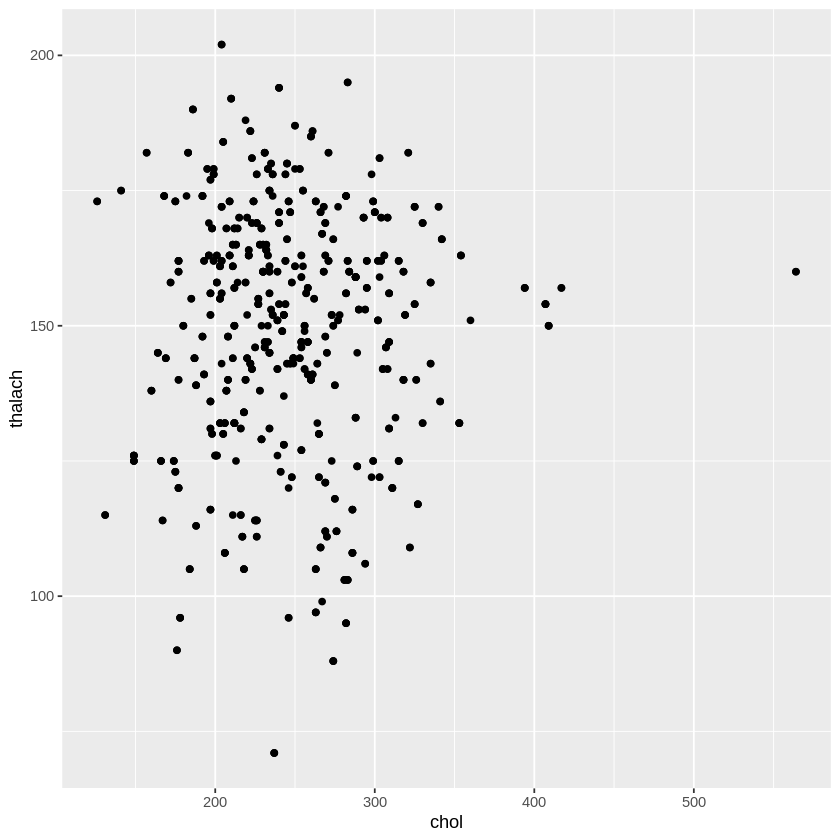

In [35]:
#distribution of points
distribution_plot <- heart_train |>
    ggplot(aes(x = chol, y = thalach)) +
    geom_point()
distribution_plot


### Tuning the K-NN classifier

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9570403,5,0.005644170,Preprocessor1_Model01
2,accuracy,binary,0.9596377,5,0.003172331,Preprocessor1_Model02
3,accuracy,binary,0.8242139,5,0.015779419,Preprocessor1_Model03
4,accuracy,binary,0.8242139,5,0.015779419,Preprocessor1_Model04
5,accuracy,binary,0.7292037,5,0.014717661,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
26,accuracy,binary,0.6913705,5,0.01945863,Preprocessor1_Model26
27,accuracy,binary,0.6925837,5,0.02535243,Preprocessor1_Model27
28,accuracy,binary,0.6951982,5,0.02385144,Preprocessor1_Model28


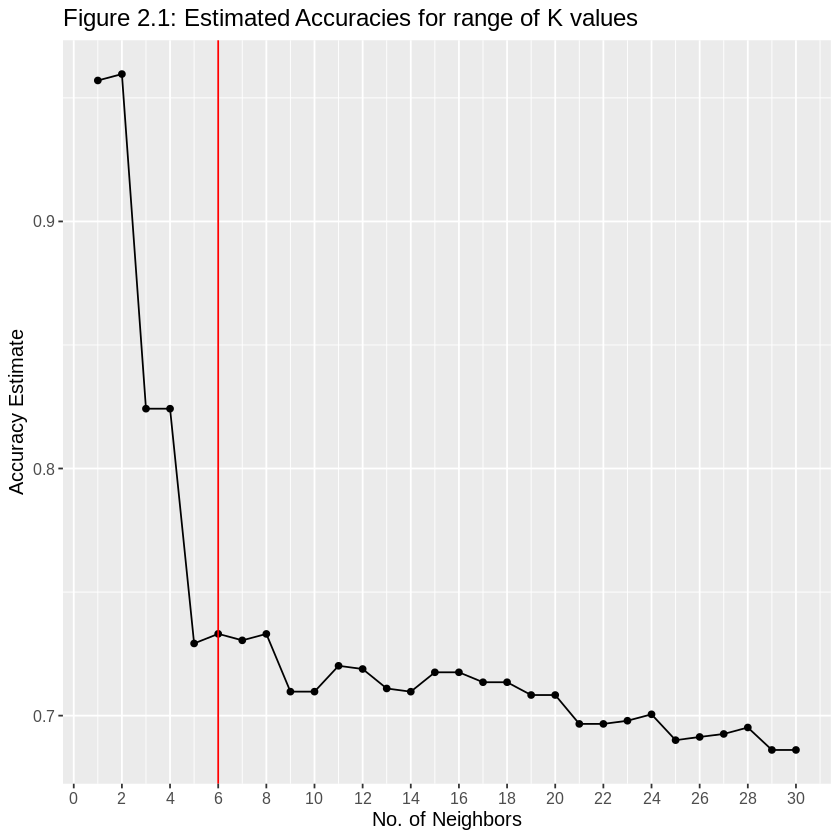

In [37]:
#set seed
set.seed(1)

#create recipe
recipe_heart <- recipe(target ~ chol + thalach, data = heart_train) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())

#parameter K value selection
#split training/validation sets
heart_vfold_2 <- vfold_cv(heart_train, v = 5, strata = target)

#train classifier part 1 - create model specifications
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

#create tibble with neighbors variable
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

#train classifier part 2 - create workflow
knn_results <- workflow() |>
        add_recipe(recipe_heart) |>
        add_model(knn_spec_2) |>
        tune_grid(resamples = heart_vfold_2, grid = k_vals) |>
        collect_metrics()

#find accuracy of the range of K values
accuracies <- knn_results |>
        filter(.metric == "accuracy")
head(accuracies, 10)
print("Table 2.0: Accuracy of k values")

#plot graph of accuracy against K value to find best K value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        geom_vline(xintercept = 6, colour = "red") +
        labs(x = "No. of Neighbors", 
             y = "Accuracy Estimate", 
             title = "Figure 2.1: Estimated Accuracies for range of K values") +
        scale_x_continuous(breaks = scales::pretty_breaks(n = 20)) +
        theme(text = element_text(size = 12))

accuracy_vs_k

We will now be tuning the classification model to find the best K value with the chosen predictors: Serum Cholesterol in mg/dl ("chol") as well as Maximum heart rate achieved ("thalach")


The following steps will be conducted:
1. Create a recipe, using columns “chol” and “thalach” as predictors. Scale and centre predictors.
2. Create a validation set to determine the number of k-nearest-neighbors that yield the most accurate predictions. Perform a 5-fold cross validation on the training data.
3. Create k-nearest-neighbor model specification. Set ‘weight_func’ argument to rectangular to obtain the straight-line distance. Set ‘neighbors’ argument to tune(). Set engine to ‘kknn’ and set mode to ‘classification’ as we are predicting categorical variables.
4. Create a workflow combining the training data recipe and model. Use tune_grid() function and set the ‘grid’ argument equal to 10 K values. Use collect_metrics() to aggregate the mean and standard error.
5. Filter for accuracies from .metric column.
6. Create a visualisation to determine the best K value. Plot neighbors against accuracy estimate (mean) to visualize the most stable k nearest neighbour.

As seen in Table 2.0 and Figure 2.1, k = 6 is the most suitable value for the number of neighbours since it has an estimated accuracy significantly higher than the other k values (excluding k=1 to k=4) and does not have a big rise or drop in accuracy compared to the values one above or one below it. K values from 1 to 4 were not chosen though their accuracy estimates were higher than k=6 as there were large fluctuations in accuracy estimates, meaning the accuracy estimate immediately falls or rises as we increase or decrease the neighbour by 1.

### K-NN classification

.metric,.estimate
<chr>,<dbl>
accuracy,0.8949416


[1] "Table 2.1: Accuracy of Predictions with K-NN Classification Model"


          Truth
Prediction   0   1
         0 108  10
         1  17 122

[1] "Table 2.2: Confusion Matrix of Prediction Results of K-NN Classification Model"


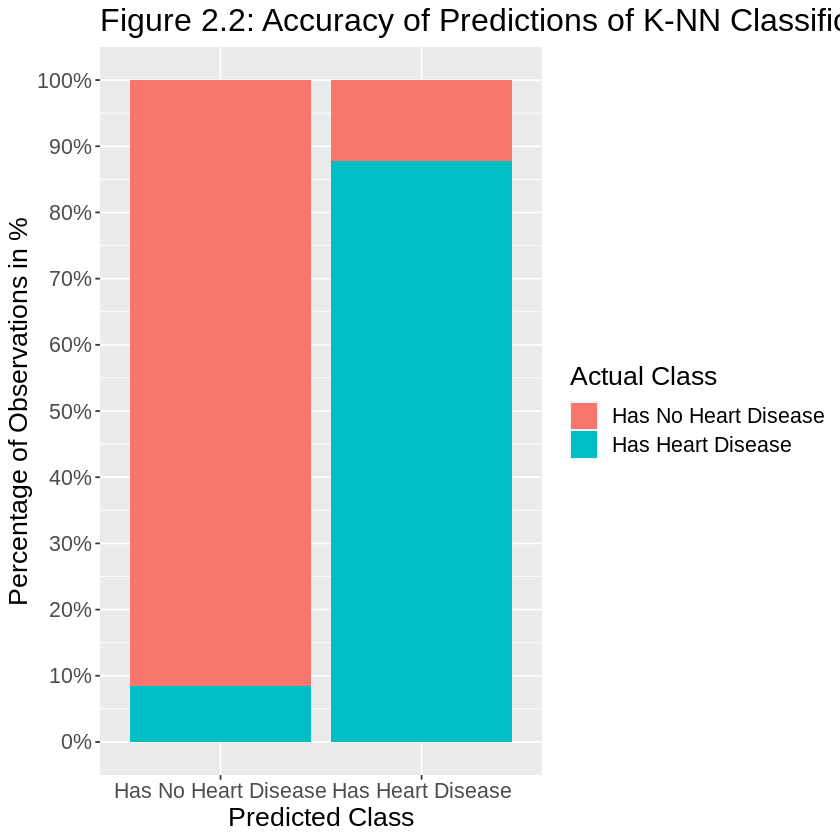

In [24]:
#create model specifications with best K value
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
        set_engine("kknn") |>
        set_mode("classification")

#create workflow
knn_fit <- workflow() |>
        add_recipe(recipe_heart) |>
        add_model(knn_spec_2) |>
        fit(data = heart_train)

#predict labels in testing dataset
heart_test_predictions <- predict(knn_fit, heart_test) |>
        bind_cols(heart_test) 

#compute classification accuracy
heart_test_predictions_2 <- heart_test_predictions |>
        metrics(truth = target, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.metric, .estimate) 
heart_test_predictions_2
print("Table 2.1: Accuracy of Predictions with K-NN Classification Model")

#create confusion matrix
confusion <- heart_test_predictions |>
        conf_mat(truth = target, estimate = .pred_class)
confusion
print("Table 2.2: Confusion Matrix of Prediction Results of K-NN Classification Model")

#create visualization from prediction outcome of model
plot <- heart_test_predictions |>
        ggplot(aes(x = .pred_class, fill = target)) +
        geom_bar(position = "fill") +
        labs(x = "Predicted Class", y = "Percentage of Observations in %",
            fill = "Actual Class") +
        ggtitle("Figure 2.2: Accuracy of Predictions of K-NN Classification Model") +
        scale_fill_discrete(labels = c("Has No Heart Disease", "Has Heart Disease")) +
        scale_y_continuous(labels = scales::label_percent(), 
                           breaks = scales::pretty_breaks(n = 10)
                           ) +
        scale_x_discrete(labels=c("0" = "Has No Heart Disease", "1" = "Has Heart Disease")) +
        theme(text = element_text(size = 16))
plot

* After we carried out K-NN classification on the testing data set, it was found that the accuracy of the trained model was at a high level of **97%**, as seen in Figure 1.2.
* We visualized the results via a confusion matrix as seen in Figure 1.3. From the matrix, it was observed that there was a total of 251 accurate predictions out of a total of 257 predictions. There were 6 cases where the actual class was "Has No Heart Disease" but the model predicted them as "Has Heart Disease".
* From Figure 1.4, we can hence see that 95% of predicted classes for "Has No Heart Disease" is accurate, while 100% of predicted classes for "Has Heart Disease" is accurate..

## Expected outcomes and significance

Heart disease patients need an immediate diagnosis.Doctors identify it based on results of clinical testing and prior experience treating patients presented with comparable symptoms. Our model will attempt to simulate a similar role, where age and maximum BPM are used to predict whether someone has heart disease. Furthermore, we expect to use a testing set to confirm the accuracy of our model. However, our current graph observes that there is a mix of points around the top middle area of the graph. We predict our classifier to have a lower accuracy for certain ranges of the data, which will cause serious health risks when misdiagnosing patients.
  
Limitations: Despite our data set having a handful of predictors that are numerical, we only use 2 that we believe are the biggest predictors. The investigation can be potentially extended by testing multiple predictors to find which one has the biggest impact. This would justify the selection of our 2 predictors from a statistical perspective. Furthermore, there is the potential to use 3 predictors at the same time to make a 3D model. However this would be hard to implement with our group’s current skills.

## References

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset